In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, month, year, to_date, round, datediff, col
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("SalesAnalys").getOrCreate()

In [3]:
df = spark.read.csv("Sample - Superstore.csv", header=True, inferSchema=True)
df.show(5)

+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|  Customer Name|  Segment|      Country|           City|     State|Postal Code|Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|     1|CA-2016-152156| 11/8/2016|11/11/2016|  Second Class|   CG-12520|    Claire Gute| Consumer|United States|      Henderson|  Kentucky|      42420| South|FUR-BO-10001798|      Furniture|   Bookcases|Bush Somerset 

# Null dəyərlər

In [4]:
df.select([i for i in df.columns if df.filter(df[i].isNull()).count() > 0]).show()

++
||
++
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
++
only showing top 20 rows



In [5]:
df.select("City").distinct().count()

531

# Hər şəhər üçün ümumi satış

In [6]:
df_sumCity = df.groupBy('City').agg(round(sum('Sales'), 2).alias('TotalSales')).orderBy('TotalSales', ascending=False).show()

+-------------+----------+
|         City|TotalSales|
+-------------+----------+
|New York City| 255248.97|
|  Los Angeles| 173168.87|
|      Seattle| 117772.58|
|San Francisco| 110917.04|
| Philadelphia| 107486.47|
|      Houston|  64389.43|
|      Chicago|  47767.33|
|    San Diego|  47115.06|
| Jacksonville|   44595.4|
|  Springfield|  42791.74|
|      Detroit|   42302.9|
|     Columbus|  37535.37|
|       Newark|  28417.28|
|    Lafayette|  25001.83|
|      Jackson|  24903.45|
|     Columbia|  24782.76|
|  San Antonio|  21843.53|
|   Burlington|  21623.33|
|    Arlington|  20204.09|
|       Dallas|  19755.09|
+-------------+----------+
only showing top 20 rows



# Hər şəhər üzrə ortalama satış

In [7]:
df_avgCity = df.groupby('City').agg(round(avg('Sales'), 2).alias('AVGSales')).orderBy('AVGSales', ascending=False).show()

+------------+--------+
|        City|AVGSales|
+------------+--------+
|   Jamestown|  2354.4|
|    Cheyenne| 1603.14|
|  Bellingham| 1263.41|
|      Sparks| 1237.88|
|Independence| 1208.69|
|     Burbank| 1082.39|
|    Torrance| 1042.06|
|     Buffalo|  906.35|
|  Burlington|  900.97|
|     Beverly|  861.06|
|     Dubuque|  836.03|
|    Appleton|  835.66|
|   Lafayette|  833.39|
| Noblesville|   772.8|
|        Lehi|  758.36|
|   Kissimmee|  751.98|
| Minneapolis|   733.5|
|  Morristown|  719.01|
|Saint Peters|  697.16|
|  Round Rock|  693.44|
+------------+--------+
only showing top 20 rows



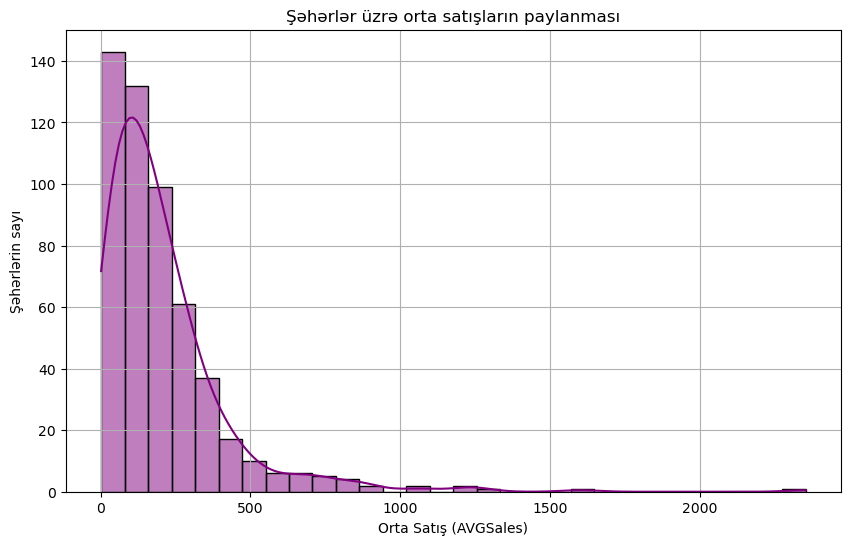

In [8]:
df_avgCity_pd=df.groupby('City').agg(avg('Sales').alias('AVGSales')).orderBy('AVGSales', ascending=False).toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(df_avgCity_pd['AVGSales'], bins=30, kde=True, color='purple')
plt.title("Şəhərlər üzrə orta satışların paylanması")
plt.xlabel("Orta Satış (AVGSales)")
plt.ylabel("Şəhərlərin sayı")
plt.grid(True)
plt.show()


# Regionlar üzrə satış

In [9]:
df_sumRegion = df.groupby('Region').agg(round(sum('Sales'), 2).alias('SumSales')).show()

+-------+---------+
| Region| SumSales|
+-------+---------+
|  South|388983.59|
|Central|497800.87|
|   East|672194.05|
|   West|713471.34|
+-------+---------+



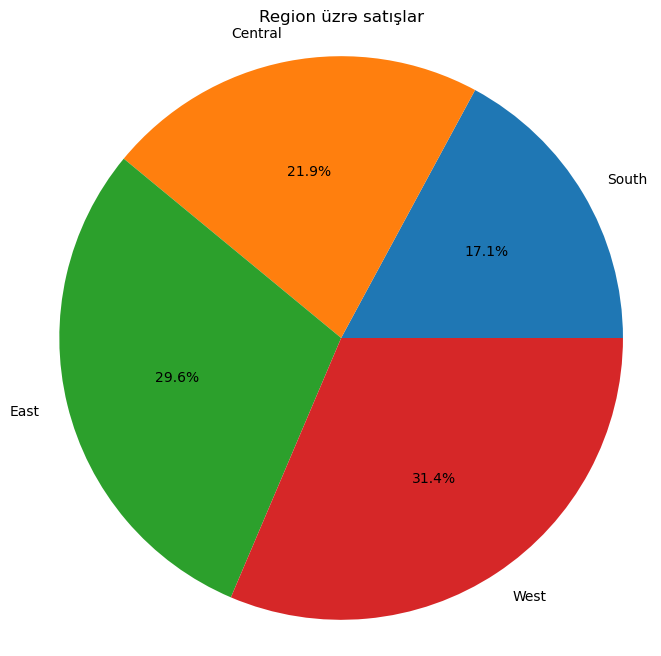

In [10]:
df_sumRegion = df.groupby('Region').agg(sum('Sales').alias('SumSales')).toPandas()
plt.figure(figsize=(8, 8))
plt.pie(df_sumRegion['SumSales'], labels=df_sumRegion['Region'], autopct='%1.1f%%')
plt.title('Region üzrə satışlar')
plt.axis('equal')
plt.show()

# Tarix formati

In [11]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [12]:
df = df.withColumn("Order Date", to_date("Order Date", "MM/dd/yyyy"))
df = df.withColumn("Ship Date", to_date("Ship Date", "MM/dd/yyyy"))

# Ayliq satışlar

In [13]:
df_month = df.groupBy(month('Order Date').alias('Month')).agg(round(sum("Sales"), 2).alias("MonthlySales")).orderBy('Month').show()

+-----+------------+
|Month|MonthlySales|
+-----+------------+
|    1|    94539.34|
|    2|    59012.83|
|    3|   203719.26|
|    4|   135387.36|
|    5|   153513.31|
|    6|   151039.43|
|    7|   145623.85|
|    8|   157642.25|
|    9|   303536.67|
|   10|    198440.0|
|   11|   348834.56|
|   12|    321161.0|
+-----+------------+



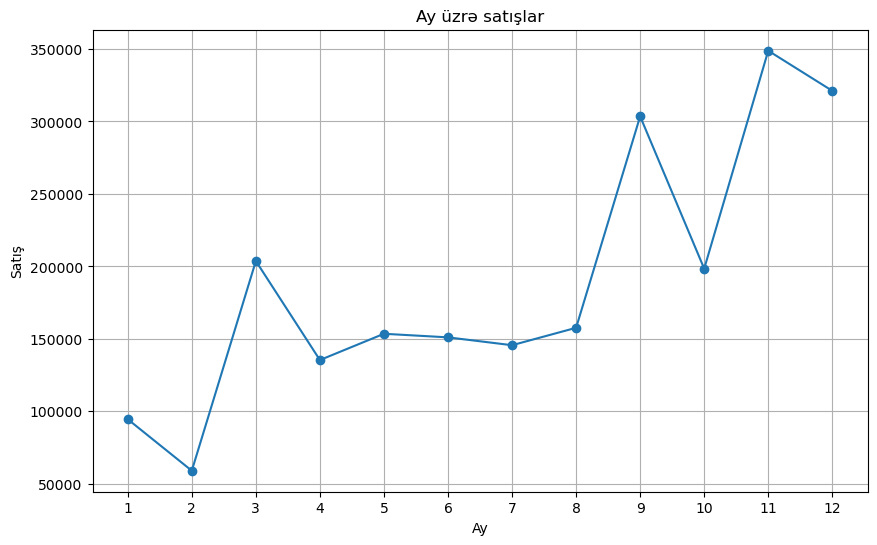

In [14]:
monthly_sales = df.groupBy(month("Order Date").alias("Month")).agg(sum("Sales").alias("MonthlySales")).orderBy("Month").toPandas()
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales["Month"], monthly_sales["MonthlySales"], marker="o")
plt.title("Ay üzrə satışlar")
plt.xlabel("Ay")
plt.ylabel("Satış")
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

# Illik satışlar

In [15]:
df_year = df.groupBy(year('Order Date').alias('Year')).agg(round(sum("Sales"), 2).alias("YearlySales")).orderBy('Year').show()

+----+-----------+
|Year|YearlySales|
+----+-----------+
|2014|   481763.8|
|2015|  464426.24|
|2016|  601265.26|
|2017|  724994.56|
+----+-----------+



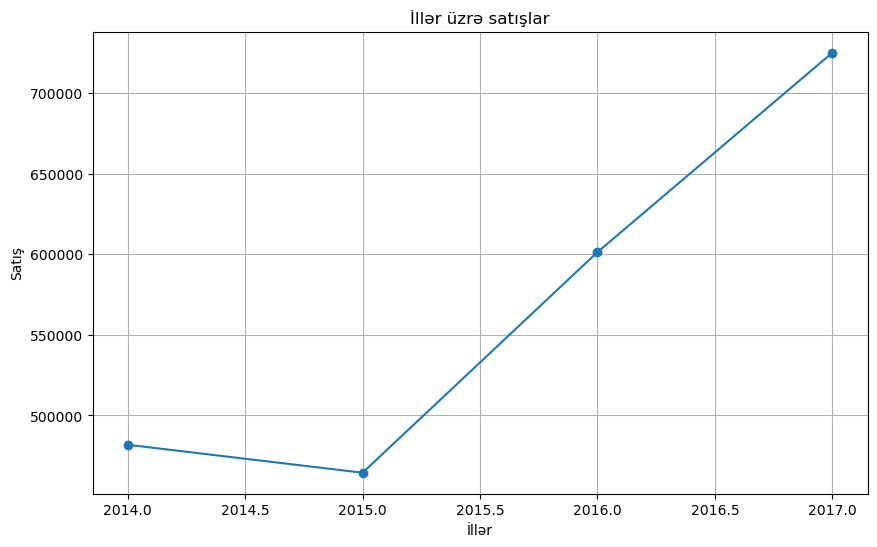

In [16]:
year_sales = df.groupBy(year('Order Date').alias('Year')).agg(sum("Sales").alias("YearlySales")).orderBy('Year').toPandas()
plt.figure(figsize=(10, 6))
plt.plot(year_sales["Year"], year_sales["YearlySales"], marker="o")
plt.title("İllər üzrə satışlar")
plt.xlabel("İllər")
plt.ylabel("Satış")
plt.grid(True)
plt.show()


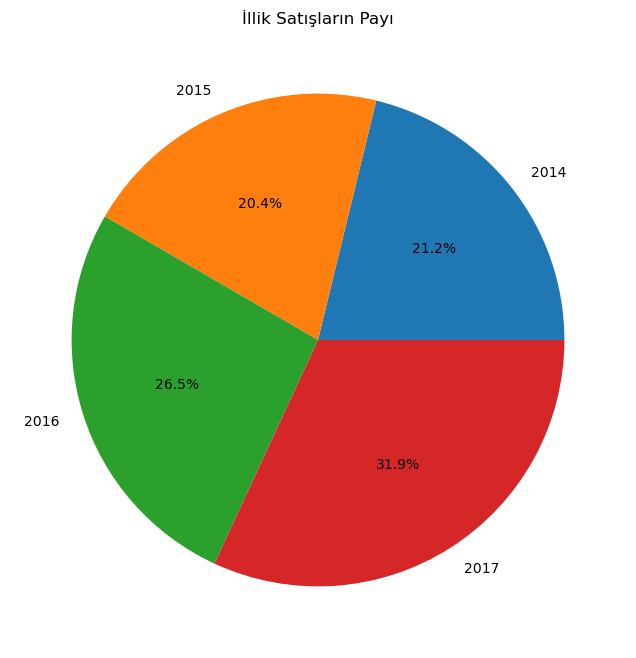

In [17]:
df_year_pie = df.groupBy(year('Order Date').alias('Year')).agg(sum("Sales").alias("YearlySales")).orderBy('Year').toPandas()
plt.figure(figsize=(8,8))
plt.pie(df_year_pie['YearlySales'], labels=df_year_pie['Year'], autopct='%1.1f%%')
plt.title("İllik Satışların Payı")
plt.show()


# Profit

In [18]:
df_profit = df.groupBy("Region").agg(round(sum("Profit"), 2).alias("TotalProfit")).show()

+-------+-----------+
| Region|TotalProfit|
+-------+-----------+
|  South|   46650.34|
|Central|    40150.5|
|   East|   91603.06|
|   West|   107303.7|
+-------+-----------+



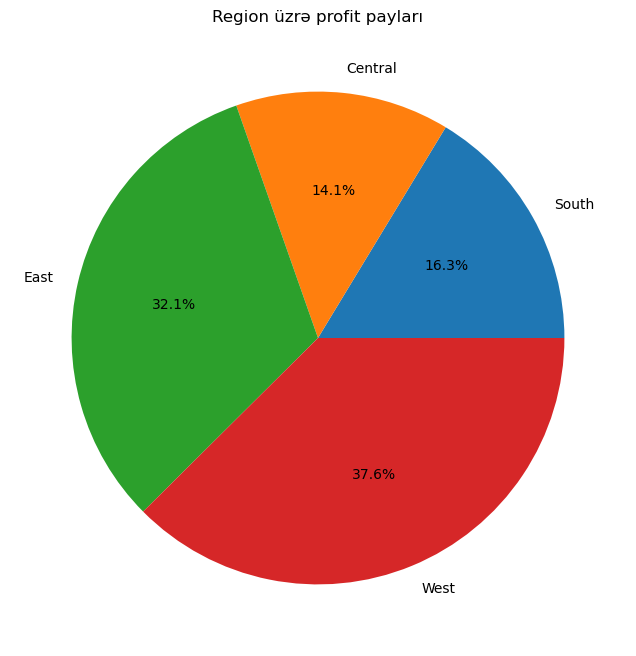

In [19]:
df_profit_pd = df.groupBy("Region").agg(sum("Profit").alias("TotalProfit")).toPandas()
plt.figure(figsize=(8,8))
plt.pie(df_profit_pd['TotalProfit'], labels=df_profit_pd['Region'], autopct='%1.1f%%')
plt.title("Region üzrə profit payları")
plt.show()



# Kateqoriyalar üzrə 

In [20]:
df_category = df.groupBy("Category").agg(round(sum("Quantity"), 2).alias("TotalQuantity")).orderBy("TotalQuantity", ascending=False).show()

+---------------+-------------+
|       Category|TotalQuantity|
+---------------+-------------+
|Office Supplies|     36867.52|
|      Furniture|     14108.88|
|     Technology|      7157.97|
+---------------+-------------+



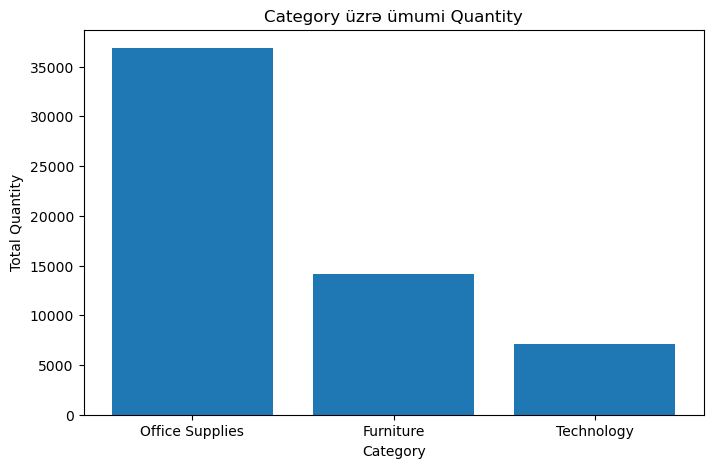

In [21]:
df_category_pd = df.groupBy("Category").agg(sum("Quantity").alias("TotalQuantity")).orderBy("TotalQuantity", ascending=False).toPandas()
plt.figure(figsize=(8,5))
plt.bar(df_category_pd['Category'], df_category_pd['TotalQuantity'])
plt.title('Category üzrə ümumi Quantity')
plt.xlabel('Category')
plt.ylabel('Total Quantity')
plt.show()


In [22]:
df_category = df.groupBy("Category").agg(round(sum("Sales"), 2).alias("TotalSales")).orderBy("TotalSales", ascending=False).show()

+---------------+----------+
|       Category|TotalSales|
+---------------+----------+
|     Technology| 835900.07|
|      Furniture| 733046.86|
|Office Supplies| 703502.93|
+---------------+----------+



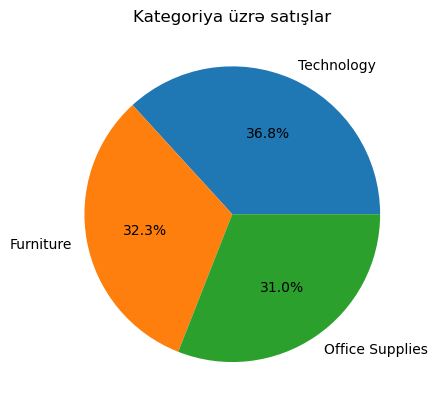

In [23]:
df_category_pd = df.groupBy("Category").agg(sum("Sales").alias("TotalSales")).orderBy("TotalSales", ascending=False).toPandas()
plt.pie(df_category_pd['TotalSales'], labels=df_category_pd['Category'], autopct='%1.1f%%')
plt.title("Kategoriya üzrə satışlar")
plt.show()



# Müştəri

In [24]:
top_customer = df.groupBy("Customer ID", "Customer Name").agg(round(sum("Quantity"), 2).alias("TotalQuantity")).orderBy("TotalQuantity", ascending=False).show()

+-----------+----------------+-------------+
|Customer ID|   Customer Name|TotalQuantity|
+-----------+----------------+-------------+
|   JD-15895|Jonathan Doherty|      1284.41|
|   DE-13255|      Deanra Eno|       989.41|
|   DK-13225|       Dean Katz|       741.55|
|   SH-19975|   Sally Hughsby|        737.6|
|   JB-16045|   Julia Barnett|       699.46|
|   AA-10645|   Anna Andreadi|       686.04|
|   KL-16555|   Kelly Lampkin|        610.7|
|   RD-19480|     Rick Duston|        584.9|
|   BS-11380|    Bill Stewart|        560.7|
|   GA-14725|   Guy Armstrong|       489.82|
|   JE-15745|      Joel Eaton|       443.36|
|   EH-13765|    Edward Hooks|        419.9|
|   MC-17575|    Matt Collins|       408.33|
|   DK-12895|     Dana Kaydos|       400.14|
|   RS-19765|  Roland Schwarz|       373.84|
|   LC-16885|  Lena Creighton|       356.35|
|   FH-14365|    Fred Hopkins|       348.54|
|   SP-20650|Stephanie Phelps|       336.92|
|   SP-20860|        Sung Pak|       331.35|
|   BW-110

In [25]:
top_customer_sales = df.groupBy("Customer ID", "Customer Name").agg(round(sum("Sales"), 2).alias("TotalSales")).orderBy('TotalSales', ascending=False).show()

+-----------+------------------+----------+
|Customer ID|     Customer Name|TotalSales|
+-----------+------------------+----------+
|   SM-20320|       Sean Miller|  25043.05|
|   TC-20980|      Tamara Chand|  19017.85|
|   RB-19360|      Raymond Buch|  15117.34|
|   TA-21385|      Tom Ashbrook|  14595.62|
|   AB-10105|     Adrian Barton|  14355.61|
|   SC-20095|      Sanjit Chand|  14142.33|
|   KL-16645|      Ken Lonsdale|  14071.92|
|   HL-15040|      Hunter Lopez|   12873.3|
|   SE-20110|      Sanjit Engle|  12209.44|
|   CC-12370|Christopher Conant|  12129.07|
|   TS-21370|      Todd Sumrall|  11885.87|
|   GT-14710|         Greg Tran|  11820.12|
|   BM-11140|      Becky Martin|   11609.9|
|   SV-20365|       Seth Vernon|  11420.65|
|   CJ-12010|   Caroline Jumper|  11079.74|
|   CL-12565|       Clay Ludtke|  10880.55|
|   ME-17320|     Maria Etezadi|  10635.92|
|   KF-16285|    Karen Ferguson|  10604.27|
|   BS-11365|      Bill Shonely|  10501.65|
|   EH-13765|      Edward Hooks|

# Çatdırılma günləri

In [26]:
df = df.withColumn("DeliverDay", datediff(col("Ship Date"), col("Order Date")))

In [27]:
df.select("Order Date", "Ship Date", "DeliverDay").orderBy('DeliverDay', ascending=False).show()

+----------+----------+----------+
|Order Date| Ship Date|DeliverDay|
+----------+----------+----------+
|2015-01-02|2015-01-09|         7|
|2016-04-22|2016-04-29|         7|
|2015-01-02|2015-01-09|         7|
|2015-10-11|2015-10-18|         7|
|2015-01-02|2015-01-09|         7|
|2017-10-26|2017-11-02|         7|
|2015-01-02|2015-01-09|         7|
|2016-11-03|2016-11-10|         7|
|2015-01-02|2015-01-09|         7|
|2017-11-05|2017-11-12|         7|
|2015-08-09|2015-08-16|         7|
|2017-11-06|2017-11-13|         7|
|2015-08-09|2015-08-16|         7|
|2017-07-06|2017-07-13|         7|
|2015-08-09|2015-08-16|         7|
|2015-04-28|2015-05-05|         7|
|2016-04-22|2016-04-29|         7|
|2015-04-28|2015-05-05|         7|
|2014-11-11|2014-11-18|         7|
|2015-04-28|2015-05-05|         7|
+----------+----------+----------+
only showing top 20 rows



# orta çatdırılma gün sayı

In [28]:
df.select(round(avg("DeliverDay"), 2).alias("AverageDeliveryDays")).show()

+-------------------+
|AverageDeliveryDays|
+-------------------+
|               3.96|
+-------------------+

